# Practical Text Classification with Python and Keras

Reading the mood from text with machine learning is called `sentiment analysis`, and it is one of the prominent use cases in text classification. This falls into the very active research field of natural language processing (NLP). Other common use cases of text classification include detection of spam, auto tagging of customer queries, and categorization of text into defined topics.

In [41]:
import pandas as pd

filepath_dict = {'yelp':   './res/data/yelp_labelled.txt',
                 'amazon': './res/data/amazon_cells_labelled.txt',
                 'imdb':   './res/data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


With this dataset, you are able to train a model to predict the sentiment of a sentence. One way you could do this is to count the frequency of each word in each sentence and tie this count back to the entire set of words in the dataset.

Begin by taking the data and creating a _vocabulary_ from all the words in all sentences. A collection of texts is also called a **corpus** in NLP. The **vocabulary** in this case is a list of words that occurred in our text where each word has its own index. This enables you to create a vector for a sentence. You would then take the sentence you want to vectorize, and you count each occurrence in the vocabulary. The resulting vector will be with the length of the vocabulary and a count for each word in the vocabulary.

The resulting vector is also called a **feature vector**. In a feature vector, each dimension can be a numeric or categorical feature, like for example the height of a building, the price of a stock, or, in our case, the count of a word in a vocabulary. These feature vectors are a crucial piece in data science and machine learning, as the model you want to train depends on them.

In [42]:
sentences = ['John likes ice cream', 'John hates chocolate.']

Next, you can use the `CountVectorizer` to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a _feature vector_ of the word counts.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

This vocabulary also serves as an index of each word. Now, you can take each sentence and get the word occurences of the words based on the previous vocabulary. This vocabulary consits of all five words in our sentences, each representing one word in the vocabulary. When you take the previous tow sentences and transform them with the `CountVectorizer` you will get a vector representing the count of each word of the sentence.

In [44]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

The resulting vectors are counts of the words ordered by their index. As you can see, the resulting indices (i.e., order of the words) dont' really matter because the resulting vectors don't depend on the position of the words in the vector.

This is considered a `Bag-of-Words (BOW)` model, which is a common way in NLP to create vectors out of text. Each document is represented as a vector. You can use these vectors now as feature vectors for a machine learning model. This leads us to our next part: defining a baseline model.

## Defining a Baseline Model

First, split the data into training and testing sets. Take the _Yelp_ dataset, which can be extracted from the pooled dataset. From there, we take the sentences and labels. The `.values` attribute returns a NumPy array instead of a Pandas series object, which is in this context easier to work with.

In [45]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

# extract the sentences and target variables
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentrain, sentest, ytrain, ytest = train_test_split(
    sentences, y, test_size=0.25, random_state=100)

Then we can use the previous `BoW` model to vectorize the sentences. You can use `CountVectorizer` again for this task. Since you might not have the testing data available during training, you can create the vocabulary using only the training data. Using this vocabulary, you can create the feature vectors for each sentence of the training and testing set.

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentrain)

xtrain = vectorizer.transform(sentrain)
xtest = vectorizer.transform(sentest)

xtrain

<750x1724 sparse matrix of type '<class 'numpy.int64'>'
	with 7422 stored elements in Compressed Sparse Row format>

You can see that the resulting feature vectors have 750 samples, which confirms the number of training samples after the test-train split from 1000 total samples. Each sample has 2505 dimensions or vocabulary words.

Also notice that this is a `sparse` matrix. This is a data type optimzed for matrices with only a few non-zero elements, which only keeps track of the non-zero elements to reduce memory load.

`CountVectorizer` performs _tokenization_, which separates sentences into a set of **tokens** as seen previously in the vocabulary. Additionally, it removes punctuation and special characters and can apply other preprocessing to each word.

> **_NOTE_** THere are many other parameters that be customized using `CountVectorizer()` such as `ngrams`, but we are ignoring it at this point to focus on building a baseline first.

The classificaiton model we are going to use is the _logistic regression_, which is a simple but powerful linear model that returns a regression value between 0 and 1 based on the input feature vector. By specifying a cutoff value (`default=0.5`), the regression model can be used for classification.

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(xtrain, ytrain)
score = clf.score(xtest, ytest)

print(f'Accurary: {score}')

Accurary: 0.808


In [48]:
# using the rest of the datasets
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    
    sentences = df_source['sentence'].values
    y =df_source['label'].values
    
    sentrain, sentest, ytrain, ytest = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentrain)
    
    # vectorize train/test data
    xtrain = vectorizer.transform(sentrain)
    xtest = vectorizer.transform(sentest)
    
    # fit to classifier and solve
    clf = LogisticRegression()
    clf.fit(xtrain, ytrain)
    score = clf.score(xtest, ytest)
    
    print(f'Accuracy for {source}: {score:.04f}')

Accuracy for yelp: 0.7960
Accuracy for amazon: 0.7960
Accuracy for imdb: 0.7487


# Introducing Keras

`Keras` is a deep learning and neural networks API capable of running on top of `tensorflow`, `theano`, or `cntk`. It doesn't handle low-level operations such as tensor manipulation and differentiation. Instead, it relies on a specialized, well-optimized tensor library, serving as the backend engine.

## Your First Keras Model

`Keras` supports two main types of models.

The `Sequential` model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the `Dense` layer, which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with (i.e., nodes).

Before building our model, we need to know the input dimension of our feature vectors. This happens only in the first layer since the following layers can do automatic shape inference. In order to biuld the `Sequential` model, you can add layers one by one in order.

In [49]:
from keras.models import Sequential
from keras import layers

input_dim = xtrain.shape[1] # number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Before you can start with the training of the model, you need to configure the learning process. This is done with the `.compile()` method. This method specifies the optimzer and the loss function.

Additionally, you can add a list of metrics for evaluation, but they do not influence the training. In this case, we want to use the `binary cross entropy` and the `adam` optimizer. Keras also includes a useful `.summary()` function to provide an overview of the model and its parameters.

In [50]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                25060     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


You might notice that we have 25060 parameters for the first layer another 11 in the second one.

- 2505 dimensions for each feature vector, over 10 nodes = 25050 features
- additionally, weights for each node accounts for 10 more = 25060 features
- finally, that node outputs to another 10 weights and 1 bias, which is another 11 parameters = 25071 features

Since training in neural networks is an iterative process, the training won't just stop after it's done. These iterations are called `epochs`. Here, we will run it for 100 epochs to be able to see how the training loss and accuracy change over each iteration.

Another parameter you have to your selection is the `batch size`. The batch size is reponsible for how many samples we want to use in one epoch, which means how many samples are used in one forward/backward pass. This increases the speed of the computation as it needs fewer epochs to run, but it also needs more memory and may degrade with larger batch sizes. Because our training set is small, we can specify a low batch size.

In [51]:
history = model.fit(xtrain, ytrain,
                    epochs=100,
                    verbose=False,
                    validation_data=(xtest,ytest),
                    batch_size=10)

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Now we can `.evaluate()` the model to measure its accuracy agains the the test targets we specified in  the `validation_data` hyperparameter.

> **_NOTE_**: The longer a neural network is trained, the more likely it is to begin **overfitting**.

If you rerun the `.fit()` method, you'll start off with the computed weights from the previous training. If you want to begin the training with a clean slate, call `clear_session()` from `keras.backend`.

In [52]:
from keras.backend import clear_session
clear_session()

In [53]:
loss, accuracy = model.evaluate(xtrain, ytrain, verbose=False)
print(f'Training Accuracy: {accuracy:.04f}')

loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print(f'Testing data: {accuracy:.04f}')

Training Accuracy: 1.0000
Testing data: 0.7914


The model is overfitting, but this was expected due to the large number of epochs relative to the model size. However, the accuracy of the testing set has already surpassed our previous logistic regression model.

Below is a helper function to visualize the loss and accuracy for the training and testing data based on the `history` callback. This callback is automatically applied to each `Keras` model and records the loss with additional metrics that can be added in the `.fit()` method.

In this case, we're only interested in the accuracy.

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid', palette='viridis', context='talk')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [55]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

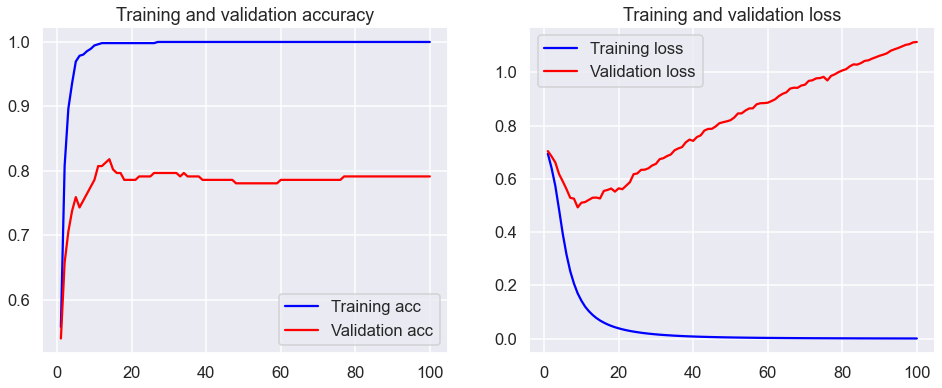

In [56]:
plot_history(history)

You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model. You can see this around 20-40 epocks in this training.

In this case, our testing and validation set are the same, since we have a smaller sample size. As we have covered before, (deep) neural networkds perform best when you have a very large number of samples. In the next part, you'll see a different way to represent words as vectors. This is a very exciting and powerful way to work with words where you'll see how to represent words as dense vectors.

## What Is a Word Embedding?

Text is considered a form of sequence data similar to time series data that you would have in weather data or financial data. In the previous BOW model, you have seen how to represent a whole sequence of words as a single feature vector. Now you will see how to reprsent each word as vectors. There are various ways to vectorize text, such as:
- Words represented by each word as a vector.
- Characters represented by each character as a vector.
- N-grams of words/characters represented as a vector (n-grams are overlapping groups of multiple succeeding words/characters in the text)

In this tutorail, you'll see how to deal with representing words as vectors which is the common way to use text in neural networks. Two possible ways to represent a word as a vector are one-hot encoding and word embeddings.

### One-Hot Encoding

The first way to represent a word as a vector is by `one-hot encoding`, which is done by taking a vector of the length of the vocabulary with an entry for each word in the corpus.

In this way, you have a vector with zeros everywhere except for the corresponding spot for the word, which is set to one. This can become a fairly large vector for each word and it does not give any additional information like the relationship between words.

In [57]:
from sklearn.preprocessing import LabelEncoder

cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']

encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)

Using this representation, you can use the `OneHotEncoder` provided by scikit-learn to encode the categorical values we got before into a one-hot-encoded numeric array. `OneHotEncoder` expects each categorical value to be in a separate row, so you'll need to reshape the array, then you can apply the encoder.

In [58]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5,1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

You can see that cateogircal integer value represents the position of the array which is 1 and the rest is 0. This is often used when you have a categorical feature which you cannot represent as a numeric value but you still want to be able to use it in machine learning. ONe use case for this encoding is in text but it is most prominently used for categories (e.g., city, department, and other categories).

### Word Embeddings

This method represents words as dense word vectors which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions. Word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geomteric space. This space is then called the **embedding space**.

This would map semantically similar words close on the embedding space like numbers or colors. If the embedding captures the relationship between words well, things like vector artihmetic should become possible. A famous example in this field is the ability to map `King` - `Man` + `Woman` = `Queen`.

One way to do this is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also.

Now you need to tokenize the data into a format that can be used by the word embeddings. `Keras` offers a couple of convenience methods for `text processing` and `sequence processing` which you can employ to prepare your text.

You can start by using the `Tokenizer` utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter `num_words`, which is responsible for setting the size of the vocabulary. The most common `num_words` words will be then kept. I have the testing and training data prepared from the previous example.

In [59]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentrain)

xtrain = tokenizer.texts_to_sequences(sentrain)
xtest = tokenizer.texts_to_sequences(sentest)

vocab_size = len(tokenizer.word_index) + 1 # adding 1 because of reserved 0 index

print(sentrain[2])
print(xtrain[2])


I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


The indexing is ordered after the most common words in the text, which you can see by the word `the` having the index `1`. It is important to note that the index `0` is reserved and is not assigned to any word. This zero-index is used for padding, which I'll introduce in a moment.

Unknown words (words not in vocabulary) are denoted in `Keras` with `word_count + 1` since they can also hold some information. You can see the index of each word by taking a look at the `word_index` dictionary of the `Tokenizer` object.

In [63]:
for word in ['the', 'all', 'fan', 'sucked']:
    print(f'{word} : {tokenizer.word_index[word]}')

the : 1
all : 27
fan : 932
sucked : 563


One problem that we have is that each text sequence is likely to have different length of words. To counter this, you can use `pad_sequence()` which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically, it doesn't matter whether or not zeros are prepended or appended.

Additionally, you would want to add a `maxlen` parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with `Keras`.

In [65]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

xtrain = pad_sequences(xtrain, padding='post', maxlen=maxlen)
xtest = pad_sequences(xtest, padding='post', maxlen=maxlen)

print(xtrain[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


The first values represent the index in the vocabulary as you have learned from the previous examples. You can also see that the resulting feature vector contains mostly zeros, since you have a fairly short sentence. In the next part, you will see how to work with word embedding.

### Keras Embedding Layer

Our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. Now you can use the `Embedding Layer` of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:
- `input_dim` : the size of the vocabulary
- `output_dim` : the size of the dense vector
- `input_length` : the length of the sequence

With the `Embedding Layer` we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a `Dense` layer. In order to tdo this, you have to add a `Flatten Layer` in between that prepares the sequenctial input for the `Dense Layer`.

In [68]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           128750    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                50010     
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.5294
Testing Accuracy:  0.4920


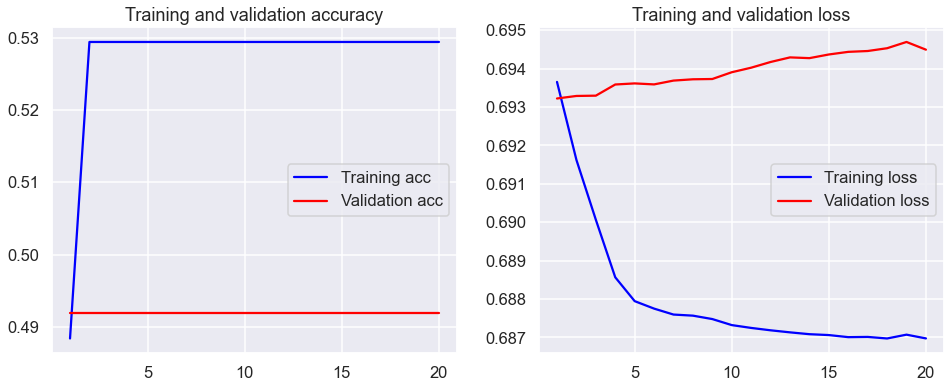

In [69]:
history = model.fit(xtrain, ytrain,
                    epochs=20,
                    verbose=False,
                    validation_data=(xtest, ytest),
                    batch_size=10)
loss, accuracy = model.evaluate(xtrain, ytrain, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data, you want to focus on methods that look at local and sequential information instead of absolute positional information.

Another way to work with embeddings is by using a `MaxPooling1D/AveragePooling1D` or a `GlobalMaxPooling1D/GlobalAveragePooling1D` layer after the embedding. You can think of the pooling layers as a way to `downsample` the incoming feature vectors.

In the case of max pooling, you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has its own layer that you can add in the sequential model.

In [70]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           128750    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7540


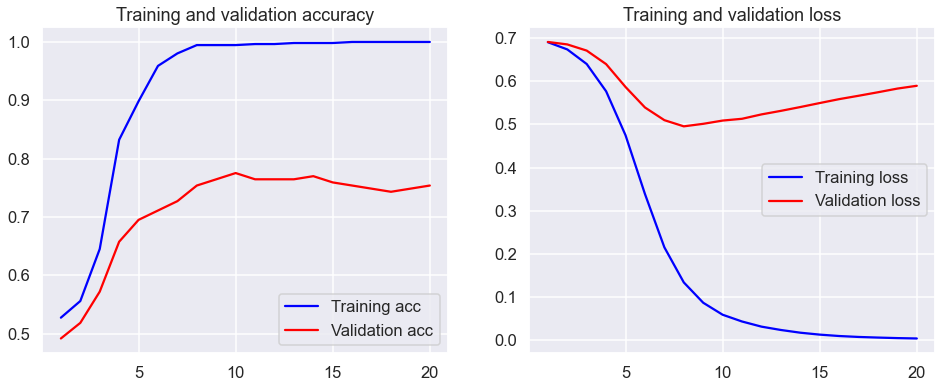

In [72]:
history = model.fit(xtrain, ytrain,
                    epochs=20,
                    verbose=False,
                    validation_data=(xtest, ytest),
                    batch_size=10)
loss, accuracy = model.evaluate(xtrain, ytrain, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)